**Importamos librerias y procesamos texto**

In [20]:
# Manipulación de datos
import pandas as pd
import numpy as np
from time import time

# Procesamiento de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualización
import matplotlib.pyplot as plt

In [21]:
# Descarga de recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Cargamos y preparamos los datos**

In [24]:
#Cargamos dataset
spam_df = pd.read_csv('spam.csv', encoding='latin-1')

# Eliminamos columnas innecesarias y renombramos las importantes (En el caso de las columnas vacias o irrelevantes)          
spam_df = spam_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
#v1 se renombra a label y v2 a message
spam_df = spam_df.rename(columns={'v1': 'label', 'v2': 'message'})

# Convertirmos las etiquetas a valores numercos (1: Spam, 0: No Spam)
spam_df['label_num'] = spam_df['label'].map({'spam': 1, 'ham': 0})
# Información básica del dataset
print(spam_df.info())
print(spam_df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5572 non-null   object
 1   message    5572 non-null   object
 2   label_num  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


In [28]:
# Filtrar las clases
spam = spam_df[spam_df['label'] == 'spam']
ham = spam_df[spam_df['label'] == 'ham']

# Duplicar la clase 'spam' hasta alcanzar el mismo número de 'ham'
df_balanced = pd.concat([ham, spam.sample(len(ham), replace=True)])

# Mezclar las filas para evitar patrones
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

print(df_balanced['label'].value_counts())


label
spam    4825
ham     4825
Name: count, dtype: int64


**Preprocesamiento de texto**

In [29]:
# Función para preprocesar el texto, donde definimos la funcion
def preprocess_text(text):
    # Convertirmos a minúsculas
    text = text.lower()
    
    # Eliminar caracteres no alfabéticos  (En el caso de Hola y hola lo tamaria como si fuera diferentes) se usa normalizacion, para eso se usa
    ##Convierte el texto a minisculas
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizar (Divide el texto en palabras individuales)
    words = nltk.word_tokenize(text)
    
    # Eliminar stopwords (palabras comunes que no aportan mucho significado como "the", "and","is"
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lematización (reduce las palabras a su forma base/raíz, como "running" se convierte en "run")
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Une las palabras procesadas en una sola cadena de texto, separadas por espacios 
    return ' '.join(words)

# Aplica la función preprocess_text a cada mensaje en la columna message del DataFrame, esto asegura que todos los mensajes esten preprocesados y listos para ser utilizados
df_balanced['processed_message'] = df_balanced['message'].apply(preprocess_text)
# Mostrar ejemplos de mensajes preprocesados
print(df_balanced[['message', 'processed_message']].head())

                                             message  \
0  FreeMsg: Fancy a flirt? Reply DATE now & join ...   
1  Buy Space Invaders 4 a chance 2 win orig Arcad...   
2  PRIVATE! Your 2003 Account Statement for shows...   
3                          K:)eng rocking in ashes:)   
4         SMS. ac sun0819 posts HELLO:\You seem cool   

                                   processed_message  
0  freemsg fancy flirt reply date join uk fastest...  
1  buy space invader chance win orig arcade game ...  
2  private account statement show unredeemed poin...  
3                                   keng rocking ash  
4                  sm ac sun post helloyou seem cool  


**Conversión de texto a características numéricas o vectorizacion del texto con TF-IDF**

In [30]:
# Convertir texto a características usando TF-IDF
#(TF): Mide la frecuencia de una palabra en un documento y (IDF) mide la importancia de una palabra en el conjunto de documentos)
#Esto quiere decir crea un objeto TfidfVectorizer que se utilizará para convertir el texto en una matriz numérica basada en TF-IDF
#(TfidfVectorizer) es una libreria que convierte txt en una matriz TF-IDF)
#5000 Reduce la dimensionalidad y evita problemas de rendimiento
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

#transforma el txt en un formato que los algoritmos de MachineLearning puedan entender
X = tfidf_vectorizer.fit_transform(df_balanced['processed_message'])
#asigna las etiquetas numéricas (label_num) a la variable y.
#y es un vector que contiene las etiquetas correspondientes a cada mensaje en X.
y = df_balanced['label_num']
print("Dimensiones de la matriz de características TF-IDF:", X.shape)

Dimensiones de la matriz de características TF-IDF: (9650, 5000)


**Division de datos**

In [31]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Dimensiones del conjunto de entrenamiento:", X_train.shape)
print("Dimensiones del conjunto de prueba:", X_test.shape)

Dimensiones del conjunto de entrenamiento: (7237, 5000)
Dimensiones del conjunto de prueba: (2413, 5000)


**Entrenamiento de los modelos SVM**

In [32]:
# Modelo SVM con kernel lineal
print("Entrenando SVM con kernel lineal...")
hora_inicio = time()

svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

tiempo_linear = time() - hora_inicio
print(f"Entrenamiento completado en {tiempo_linear:.2f} segundos")

# Modelo SVM con kernel RBF
print("\nEntrenando SVM con kernel RBF...")
hora_inicio = time()

svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

tiempo_rbf = time() - hora_inicio
print(f"Entrenamiento completado en {tiempo_rbf:.2f} segundos")

Entrenando SVM con kernel lineal...
Entrenamiento completado en 1.26 segundos

Entrenando SVM con kernel RBF...
Entrenamiento completado en 2.06 segundos


**Evaluación de los modelos**

In [33]:
# Evaluar modelo con kernel lineal
print("\nEvaluación del modelo con kernel lineal:")
hora_inicio = time()
y_pred_linear = svm_linear.predict(X_test)
print(f"Predicción completada en {time() - hora_inicio:.4f} segundos")

precision_linear = accuracy_score(y_test, y_pred_linear)
print(f"Precisión del modelo lineal: {precision_linear:.4f}")

conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
print("Matriz de confusión (kernel lineal):")
print(conf_matrix_linear)

# Evaluar modelo con kernel RBF
print("\nEvaluación del modelo con kernel RBF:")
hora_inicio = time()
y_pred_rbf = svm_rbf.predict(X_test)
print(f"Predicción completada en {time() - hora_inicio:.4f} segundos")

precision_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Precisión del modelo RBF: {precision_rbf:.4f}")

conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
print("Matriz de confusión (kernel RBF):")
print(conf_matrix_rbf)


Evaluación del modelo con kernel lineal:
Predicción completada en 0.3374 segundos
Precisión del modelo lineal: 0.9934
Matriz de confusión (kernel lineal):
[[1182   12]
 [   4 1215]]

Evaluación del modelo con kernel RBF:
Predicción completada en 0.6118 segundos
Precisión del modelo RBF: 0.9971
Matriz de confusión (kernel RBF):
[[1191    3]
 [   4 1215]]


**Visualización de resultados**

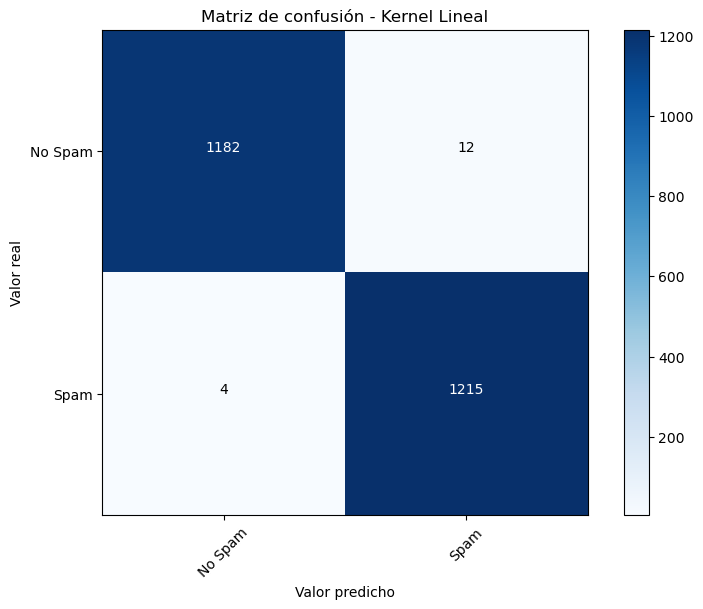

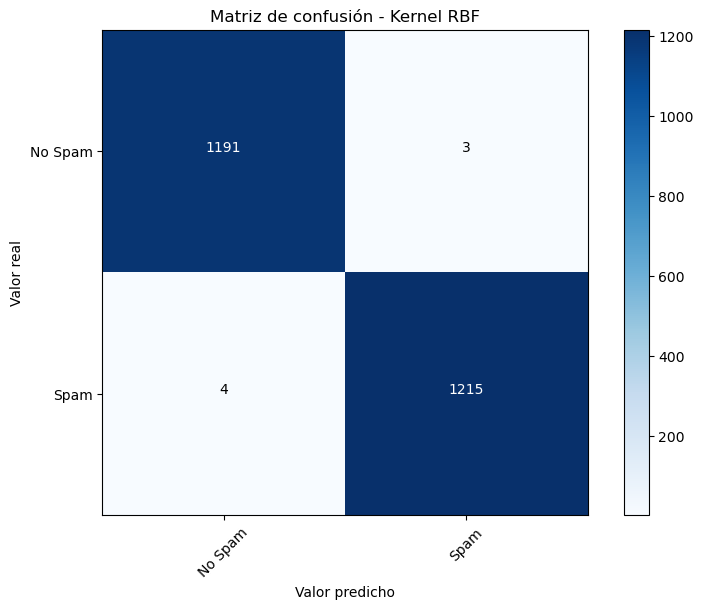

In [34]:
# Función para visualizar matrices de confusión
def plot_cm(cm, classes, title='Matriz de confusión'):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Anotar los valores en cada celda
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Valor predicho')
    plt.show()

# Visualizar matriz de confusión para kernel lineal
plot_cm(conf_matrix_linear, ['No Spam', 'Spam'], 'Matriz de confusión - Kernel Lineal')

# Visualizar matriz de confusión para kernel RBF
plot_cm(conf_matrix_rbf, ['No Spam', 'Spam'], 'Matriz de confusión - Kernel RBF')

**Informes de clasificacion detallados**


Informe de clasificación - Kernel Lineal:
              precision    recall  f1-score   support

     No Spam       1.00      0.99      0.99      1194
        Spam       0.99      1.00      0.99      1219

    accuracy                           0.99      2413
   macro avg       0.99      0.99      0.99      2413
weighted avg       0.99      0.99      0.99      2413


Informe de clasificación - Kernel RBF:
              precision    recall  f1-score   support

     No Spam       1.00      1.00      1.00      1194
        Spam       1.00      1.00      1.00      1219

    accuracy                           1.00      2413
   macro avg       1.00      1.00      1.00      2413
weighted avg       1.00      1.00      1.00      2413



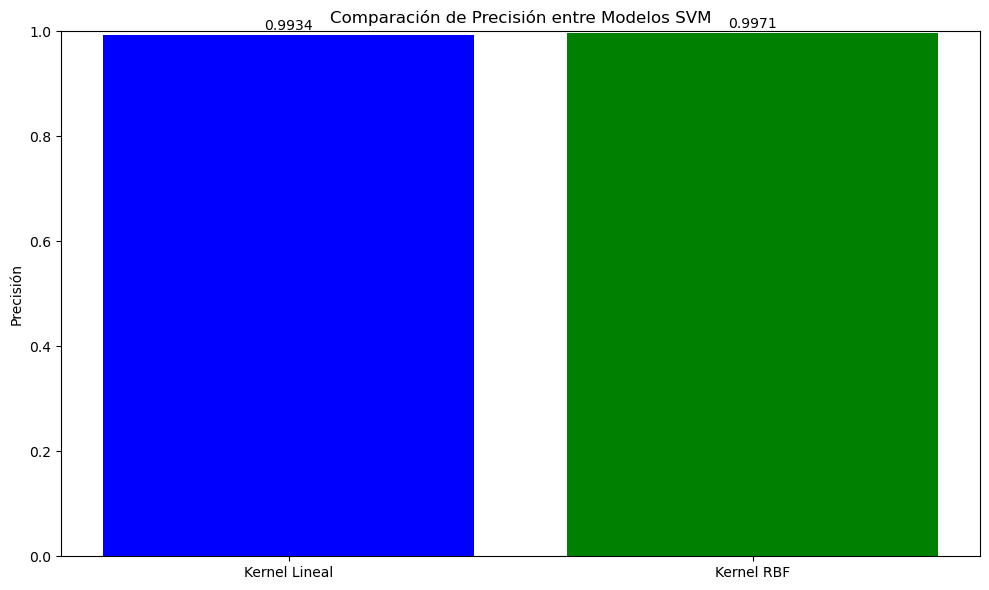

In [35]:
# Comparación de rendimiento entre modelos
print("\nInforme de clasificación - Kernel Lineal:")
print(classification_report(y_test, y_pred_linear, target_names=['No Spam', 'Spam']))

print("\nInforme de clasificación - Kernel RBF:")
print(classification_report(y_test, y_pred_rbf, target_names=['No Spam', 'Spam']))

# Visualizar comparación de precisión
modelos = ['Kernel Lineal', 'Kernel RBF']
precisiones = [precision_linear, precision_rbf]

plt.figure(figsize=(10, 6))
plt.bar(modelos, precisiones, color=['blue', 'green'])
plt.title('Comparación de Precisión entre Modelos SVM')
plt.ylabel('Precisión')
plt.ylim([0, 1])

# Añadir etiquetas de valor en cada barra
for i, v in enumerate(precisiones):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

**Función para clasificar nuevos mensajes**

In [98]:
def clasificar_mensaje(mensaje, vectorizador, modelo):
    # Preprocesar el mensaje
    mensaje_procesado = preprocess_text(mensaje)
    
    # Vectorizar
    X_mensaje = vectorizador.transform([mensaje_procesado])
    
    # Predecir
    prediccion = modelo.predict(X_mensaje)[0]
    
    # Retornar resultado
    if prediccion == 1:
        return "SPAM"
    else:
        return "NO SPAM"

# Ejemplo de uso
mensajes_prueba = [
    "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.",
    "Hi Tom, how are you doing? Do you want to meet up for coffee this weekend?",
    "Congratulations! You've won a free iPhone. Click here to claim your prize now!",
    "Meeting is postponed until tomorrow 10am. Please inform the team."
]

print("\nClasificación de mensajes de prueba usando el modelo SVM con kernel lineal:")
for mensaje in mensajes_prueba:
    resultado = clasificar_mensaje(mensaje, tfidf_vectorizer, svm_linear)
    print(f"Mensaje: {mensaje[:50]}... -> {resultado}")


Clasificación de mensajes de prueba usando el modelo SVM con kernel lineal:
Mensaje: WINNER!! As a valued network customer you have bee... -> SPAM
Mensaje: Hi Tom, how are you doing? Do you want to meet up ... -> NO SPAM
Mensaje: Congratulations! You've won a free iPhone. Click h... -> SPAM
Mensaje: Meeting is postponed until tomorrow 10am. Please i... -> NO SPAM
